
# 🌳 DETECCIÓN DE ÁRBOLES CON DEEPFOREST



## Importe de dependencias


In [1]:
import os
import rasterio
from rasterio.windows import Window
from rasterio.warp import transform_bounds
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import warnings
import sklearn
import torch
import deepforest
warnings.filterwarnings('ignore')

c:\Users\Brayan\Desktop\Proyecto\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Definición de  rutas principales

In [3]:
raster_path = "C:/Users/Brayan/Desktop/Proyecto/docs/Raster_maduro2.tif"
vector_path = "C:/Users/Brayan/Desktop/Proyecto/docs/Vector1.shp"
output_dir = "C:/Users/Brayan/Desktop/Salida infierno/DEepforest"
os.makedirs(output_dir, exist_ok=True)

In [4]:
import rasterio
from rasterio.enums import Resampling

with rasterio.open(raster_path) as src:
    img = src.read([1, 2, 3], out_dtype='uint8', resampling=Resampling.nearest)  # toma solo las 3 primeras bandas
    profile = src.profile
    profile.update(count=3, dtype='uint8')

rgb_path = os.path.join(output_dir, "raster_RGB.tif")
with rasterio.open(rgb_path, 'w', **profile) as dst:
    dst.write(img)

raster_path = rgb_path
print(f"✅ Raster convertido a RGB en: {rgb_path}")

✅ Raster convertido a RGB en: C:/Users/Brayan/Desktop/Salida infierno/DEepforest\raster_RGB.tif


In [5]:
# --- 3. DIVIDIR RASTER EN TILES (400x400 píxeles con overlap) ---
tile_size = 900
overlap = 250  # Píxeles de solapamiento entre tiles
tiles_dir = os.path.join(output_dir, "images")
os.makedirs(tiles_dir, exist_ok=True)

print("📦 Generando tiles con overlap...")
tile_metadata = []

with rasterio.open(raster_path) as src:
    print(f"📐 Dimensiones del raster: {src.width}x{src.height}")
    print(f"📍 CRS: {src.crs}")

    # Calcular stride (paso entre tiles)
    stride = tile_size - overlap

    for i in tqdm(range(0, src.height, stride)):
        for j in tqdm(range(0, src.width, stride)): # Added tqdm for inner loop
            # Ajustar el tamaño si estamos cerca del borde
            actual_height = min(tile_size, src.height - i)
            actual_width = min(tile_size, src.width - j)

            window = Window(j, i, actual_width, actual_height)
            transform = src.window_transform(window)

            # Nombre único del tile
            tile_name = f"tile_{i}_{j}.png"
            outpath = os.path.join(tiles_dir, tile_name)

            # Read data
            data = src.read(window=window)

            # Convert to RGB if necessary (DeepForest requires RGB)
            if data.shape[0] >= 3:
                rgb_data = data[:3, :, :]
            else:
                # If only 1 band, replicate it
                rgb_data = np.stack([data[0, :, :]] * 3, axis=0)

            # Normalize to 0-255
            rgb_data = np.clip(rgb_data, 0, 255).astype(np.uint8)

            # Save as PNG (more efficient for DeepForest)
            img = Image.fromarray(np.transpose(rgb_data, (1, 2, 0)))
            img.save(outpath)

            # Save metadata for coordinate mapping
            bounds = src.window_bounds(window)
            tile_metadata.append({
                'tile_name': tile_name,
                'col_off': j,
                'row_off': i,
                'width': actual_width,
                'height': actual_height,
                'bounds': bounds
            })

print(f"✅ {len(tile_metadata)} tiles generated in: {tiles_dir}")

# --- 4. LEER POLÍGONOS Y AJUSTAR CRS ---
trees = gpd.read_file(vector_path)
print(f"🌲 Polígonos cargados: {len(trees)}")
print(f"   CRS original: {trees.crs}")

with rasterio.open(raster_path) as src:
    raster_crs = src.crs

if trees.crs != raster_crs:
    print(f"🔄 Reproyecting to {raster_crs}...")
    trees = trees.to_crs(raster_crs)

# Validate geometries
trees = trees[trees.is_valid]
print(f"✅ Valid polygons: {len(trees)}")

# --- 5. ASOCIAR POLÍGONOS A CADA TILE ---
annotations = []
trees_per_tile = {}

print("📍 Extracting bounding boxes per tile...")
with rasterio.open(raster_path) as src:
    for tile_info in tqdm(tile_metadata):
        tile_name = tile_info['tile_name']
        j = tile_info['col_off']
        i = tile_info['row_off']

        # Create bounding box of the tile in geographic coordinates
        bounds = tile_info['bounds']
        tile_bbox = box(*bounds)

        # Find trees that intersect this tile
        subset = trees[trees.intersects(tile_bbox)]

        if subset.empty:
            continue

        trees_per_tile[tile_name] = len(subset)

        for _, row in subset.iterrows():
            geom = row.geometry
            xmin_geo, ymin_geo, xmax_geo, ymax_geo = geom.bounds

            # Convert geographic coordinates to tile pixels
            # rasterio.transform.rowcol converts geo -> pixel
            py_min, px_min = src.index(xmin_geo, ymax_geo)
            py_max, px_max = src.index(xmax_geo, ymin_geo) # Corrected from ymin_tile

            # Convert to relative tile coordinates
            xmin_tile = px_min - j
            ymin_tile = py_min - i
            xmax_tile = px_max - j
            ymax_tile = py_max - i

            # Clip to tile boundaries
            xmin_tile = max(0, min(xmin_tile, tile_info['width']))
            ymin_tile = max(0, min(ymin_tile, tile_info['height']))
            xmax_tile = max(0, min(xmax_tile, tile_info['width']))
            ymax_tile = max(0, min(ymax_tile, tile_info['height']))

            # Check if the bounding box is valid
            if xmax_tile > xmin_tile and ymax_tile > ymin_tile:
                # Calculate minimum area (filter very small detections)
                area = (xmax_tile - xmin_tile) * (ymax_tile - ymin_tile)
                if area >= 25:  # At least 5x5 pixels
                    annotations.append({
                        "image_path": tile_name,
                        "xmin": int(xmin_tile),
                        "ymin": int(ymin_tile),
                        "xmax": int(xmax_tile),
                        "ymax": int(ymax_tile),
                        "label": "Tree"
                    })

print(f"📊 Statistics:")
print(f"   - Tiles with trees: {len(trees_per_tile)}")
print(f"   - Total annotations: {len(annotations)}")
if trees_per_tile:
    print(f"   - Average trees/tile: {np.mean(list(trees_per_tile.values())):.1f}")

# --- 6. SAVE ANNOTATIONS.CSV ---
ann_path = os.path.join(output_dir, "annotations.csv")
df = pd.DataFrame(annotations)

if df.empty:
    print("⚠️ ERROR: No annotations generated. Check:")
    print("   1. That the shapefile and raster overlap spatially")
    print("   2. That the CRSs are compatible")
    print("   3. That the polygons are valid")
else:
    df.to_csv(ann_path, index=False)
    print(f"✅ Annotation file saved to: {ann_path}")
    print("\n📋 First annotations:")
    print(df.head(10))

    # Split into train/val (80/20)
    from sklearn.model_selection import train_test_split
    unique_images = df['image_path'].unique()
    train_imgs, val_imgs = train_test_split(unique_images, test_size=0.2, random_state=42)

    train_df = df[df['image_path'].isin(train_imgs)]
    val_df = df[df['image_path'].isin(val_imgs)]

    train_path = os.path.join(output_dir, "train_annotations.csv")
    val_path = os.path.join(output_dir, "val_annotations.csv")

    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)

    print(f"\n📂 Datasets:")
    print(f"   - Train: {len(train_df)} annotations ({len(train_imgs)} images)")
    print(f"   - Val: {len(val_df)} annotations ({len(val_imgs)} images)")

📦 Generando tiles con overlap...
📐 Dimensiones del raster: 13105x10998
📍 CRS: EPSG:32618


100%|██████████| 17/17 [00:31<00:00,  1.85s/it]


✅ 357 tiles generated in: C:/Users/Brayan/Desktop/Salida infierno/DEepforest\images
🌲 Polígonos cargados: 666
   CRS original: EPSG:32618
✅ Valid polygons: 666
📍 Extracting bounding boxes per tile...


100%|██████████| 357/357 [00:00<00:00, 1180.42it/s]

📊 Statistics:
   - Tiles with trees: 145
   - Total annotations: 1116
   - Average trees/tile: 10.1
✅ Annotation file saved to: C:/Users/Brayan/Desktop/Salida infierno/DEepforest\annotations.csv

📋 First annotations:
           image_path  xmin  ymin  xmax  ymax label
0     tile_0_8450.png   372     0   900   364  Tree
1     tile_0_9100.png     0     0   900   364  Tree
2     tile_0_9750.png     0     0   533   364  Tree
3  tile_1950_3900.png   871   558   900   900  Tree
4  tile_1950_3900.png   666   802   900   900  Tree
5  tile_1950_4550.png   221   558   593   900  Tree
6  tile_1950_4550.png   633   786   850   900  Tree
7  tile_1950_4550.png    16   802   351   900  Tree
8  tile_1950_5200.png     0   786   200   900  Tree
9  tile_2600_3900.png   871     0   900   262  Tree

📂 Datasets:
   - Train: 849 annotations (116 images)
   - Val: 267 annotations (29 images)


In [ ]:
# --- 7. TRAIN DEEPFOREST MODEL ---
#import os
#import torch
from deepforest import main
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# --- CONFIGURAR DISPOSITIVO ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️ Using: {device}")

# --- CREAR Y CONFIGURAR MODELO ---
model = main.deepforest()
model.config["train"]["csv_file"] = train_path
model.config["train"]["root_dir"] = tiles_dir
model.config["train"]["fast_dev_run"] = False
model.config["batch_size"] = 3
model.config["score_thresh"] = 0.2
model.config["train"]["epochs"] = 5
model.config["validation"]["size"] = 900

# --- CARGAR PESOS PREENTRENADOS ---
model.load_model()
print("✅ Pretrained weights loaded")

# --- CONFIGURAR CALLBACKS ---
checkpoint_callback = ModelCheckpoint(
    monitor="train_loss_epoch",
    mode="min",
    save_top_k=1,
    dirpath=output_dir,
    filename="best_model-{epoch:02d}-{train_loss_epoch:.2f}"
)

early_stop_callback = EarlyStopping(
    monitor="train_loss_epoch",
    patience=5,
    mode="min"
)

# Agregar callbacks al trainer antes del entrenamiento
model.trainer.callbacks.extend([checkpoint_callback, early_stop_callback])

# --- ENTRENAR MODELO ---
print("\n🚀 Starting training...")
print("=" * 50)

try:
    model.trainer.fit(model)

    # Guardar el modelo final (último estado del entrenamiento)
    model_path = os.path.join(output_dir, "deepforest_citricos_final.ckpt")
    model.trainer.save_checkpoint(model_path)
    print(f"\n✅ Último modelo guardado en: {model_path}")

    # Mostrar la ruta del mejor modelo guardado automáticamente
    best_model_path = checkpoint_callback.best_model_path
    print(f"🏆 Mejor modelo guardado automáticamente en: {best_model_path}")

except Exception as e:
    print(f"⚠️ Error durante entrenamiento: {e}")
    print("👉 Intenta reducir el batch_size o revisar las anotaciones")



GPU available: False, used: False
TPU available: False, using: 0 TPU cores



🖥️ Using: cpu



  | Name                 | Type                  | Params | Mode 
-----------------------------------------------------------------------
0 | iou_metric           | IntersectionOverUnion | 0      | train
1 | mAP_metric           | MeanAveragePrecision  | 0      | train
2 | empty_frame_accuracy | BinaryAccuracy        | 0      | train
3 | model                | RetinaNetHub          | 32.1 M | train
-----------------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)
205       Modules in train mode
0         Modules in eval mode


✅ Pretrained weights loaded

🚀 Starting training...
Epoch 0: 100%|██████████| 39/39 [05:29<00:00,  0.12it/s, v_num=9]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 39/39 [05:30<00:00,  0.12it/s, v_num=9]

✅ Último modelo guardado en: C:/Users/Brayan/Desktop/Salida infierno/DEepforest\deepforest_citricos_final.ckpt
🏆 Mejor modelo guardado automáticamente en: C:\Users\Brayan\Desktop\Salida infierno\DEepforest\best_model-epoch=00-train_loss_epoch=1.05.ckpt

📊 Evaluating on validation set...
Predicting DataLoader 0: 100%|██████████| 10/10 [00:31<00:00,  0.32it/s]

📈 Evaluation metrics:
{'results':      prediction_id  truth_id       IoU     score  \
0              3.0         0  0.105382  0.283397   
1              1.0         1  0.511621  0.331194   
2              1.0         0  0.767375  0.397711   
3              0.0         1  0.762114  0.429178   
4              5.0         2  0.646403  0.283175   
..             ...       ...       ...       ...   
262            6.0         7  0.748601  0.250411   
263            4.0         8  0.702145  0.294982   
264            7.0         9  0.540487  0.200813   
265            Na

NameError: name 'glob' is not defined

In [25]:
# corte aqui
# --- 8. EVALUATE MODEL ---
import os
import glob
import pandas as pd

if not val_df.empty and os.path.exists(model_path):
    print("\n📊 Evaluating on validation set...")
    results = model.evaluate(
        csv_file=val_path,
        root_dir=tiles_dir,
        iou_threshold=0.4,
        size=model.config["validation"]["size"]
        )
    print("\n📈 Evaluation metrics:")
    print(results)


# --- 9. PREDICCIÓN POR TILES Y GUARDADO ---
print("\n💾 Ejecutando predicciones por tiles grandes...")

preds_dir = os.path.join(output_dir, "predicciones_tiles")
os.makedirs(preds_dir, exist_ok=True)

# Aquí se guardan los CSV de cada tile
model.predict_tile(
    path=raster_path,   # Usa raster_path, no 'path'
    patch_size=800,
    patch_overlap=0.2,
    #savedir=preds_dir          # 🔥 Guarda los resultados aquí
    )
# Guardar resultados manualmente
preds_path = os.path.join(preds_dir, "predicciones_tiles.csv")
predictions.to_csv(preds_path, index=False)
print(f"✅ Predicciones guardadas en: {preds_path}")

# Combinar todos los CSV en uno solo
csv_files = glob.glob(os.path.join(preds_dir, "*.csv"))
if csv_files:
    preds_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
    combined_path = os.path.join(output_dir, "predicciones_combinadas.csv")
    preds_df.to_csv(combined_path, index=False)
    print(f"✅ Predicciones combinadas guardadas en: {combined_path}")
else:
    print("⚠️ No se encontraron archivos CSV en las predicciones.")



📊 Evaluating on validation set...
Predicting DataLoader 0: 100%|██████████| 10/10 [00:26<00:00,  0.37it/s]

📈 Evaluation metrics:
{'results':      prediction_id  truth_id       IoU     score  \
0              3.0         0  0.105382  0.283397   
1              1.0         1  0.511621  0.331194   
2              1.0         0  0.767375  0.397711   
3              0.0         1  0.762114  0.429178   
4              5.0         2  0.646403  0.283175   
..             ...       ...       ...       ...   
262            6.0         7  0.748601  0.250411   
263            4.0         8  0.702145  0.294982   
264            7.0         9  0.540487  0.200813   
265            NaN        10  0.000000       NaN   
266            3.0        11  0.719962  0.296872   

                                              geometry predicted_label  \
0    POLYGON ((900 259, 900 574, 755 574, 755 259, ...            Tree   
1    POLYGON ((513 0, 513 129, 146 129, 146 0, 513 0))            Tree   
2    POLYG


🖼️ Generating sample predictions...
Predicting C:/Users/Brayan/Desktop/Salida infierno/DEepforest\images\tile_6500_5200.png...
Predicting C:/Users/Brayan/Desktop/Salida infierno/DEepforest\images\tile_10400_3900.png...
Predicting C:/Users/Brayan/Desktop/Salida infierno/DEepforest\images\tile_4550_3250.png...
✅ Visualization saved to: C:/Users/Brayan/Desktop/Salida infierno/DEepforest\sample_predictions.png


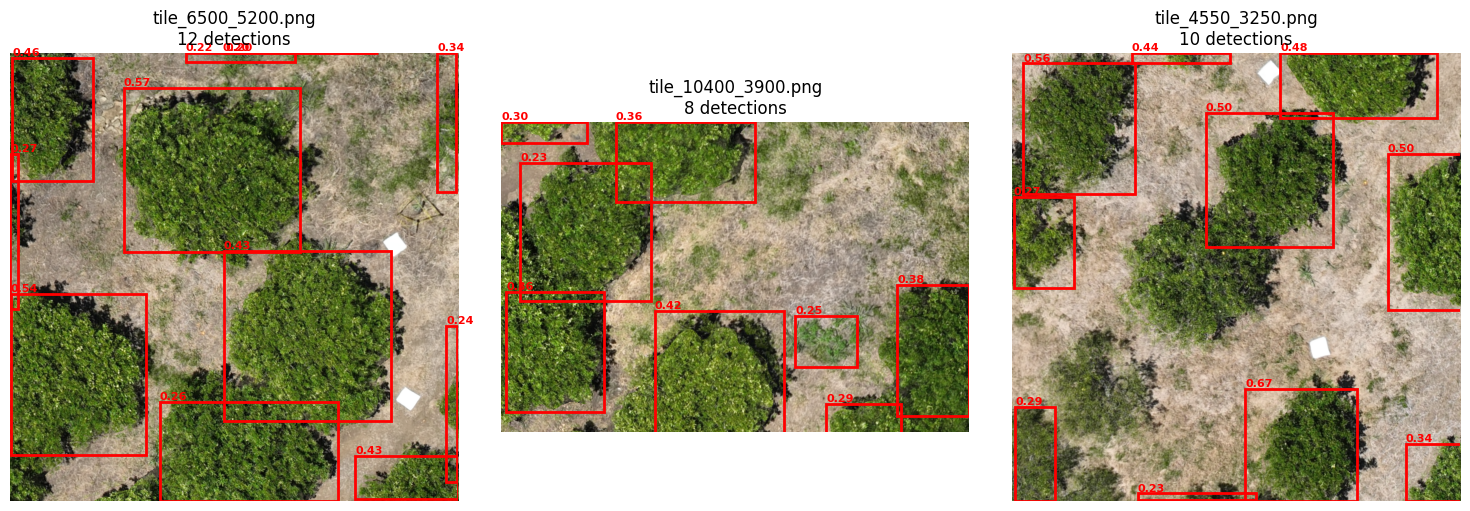

In [12]:

# --- 9. VISUALIZE SAMPLE PREDICTIONS ---
import os
import matplotlib.pyplot as plt
from PIL import Image

sample_tiles = val_imgs[:3] if len(val_imgs) >= 3 else list(unique_images)[:3]
if len(sample_tiles) == 0:
    sample_tiles = [val_imgs[0]]

fig, axes = plt.subplots(1, len(sample_tiles), figsize=(15, 5))
if len(sample_tiles) == 1:
    axes = [axes]

print("\n🖼️ Generating sample predictions...")
for idx, tile_name in enumerate(sample_tiles):
    tile_path = os.path.join(tiles_dir, tile_name)
    print(f"Predicting {tile_path}...")

    # Predict
    pred_df = model.predict_image(path=tile_path)

    # Load image
    img = Image.open(tile_path)
    axes[idx].imshow(img)

    # Draw predictions
    if pred_df is not None and not pred_df.empty:
        for _, row in pred_df.iterrows():
            rect = plt.Rectangle(
                (row['xmin'], row['ymin']),
                row['xmax'] - row['xmin'],
                row['ymax'] - row['ymin'],
                fill=False,
                edgecolor='red',
                linewidth=2
            )
            axes[idx].add_patch(rect)
            axes[idx].text(
                row['xmin'], row['ymin'] - 5,
                f"{row['score']:.2f}",
                color='red',
                fontsize=8,
                weight='bold'
            )

    axes[idx].set_title(f"{tile_name}\n{len(pred_df) if pred_df is not None else 0} detections")
    axes[idx].axis('off')

plt.tight_layout()
preds_path = os.path.join(output_dir, "sample_predictions.png")
plt.savefig(preds_path, dpi=150, bbox_inches='tight')
print(f"✅ Visualization saved to: {preds_path}")
plt.show()


📂 Cargando datos de validación...
✓ 267 anotaciones cargadas

🔮 Generando predicciones...
Predicting DataLoader 0: 100%|██████████| 10/10 [00:36<00:00,  0.28it/s]
✓ 216 predicciones generadas

📊 Preparando datos para evaluación...

🔍 Agrupando predicciones por imagen...
Total de imágenes únicas: 29

📊 Resultados del emparejamiento:
✓ Imágenes con predicciones: 29
⚠️ Imágenes sin predicciones: 0
Ground truth: 29 muestras
Predicciones: 29 muestras

📈 Calculando métricas...

📊 RESULTADOS DEL MODELO
✓ Accuracy:  0.0000 (0.00%)
✓ Precision: 0.0000
✓ Recall:    0.0000
✓ F1-Score:  0.0000

📊 Generando visualizaciones...



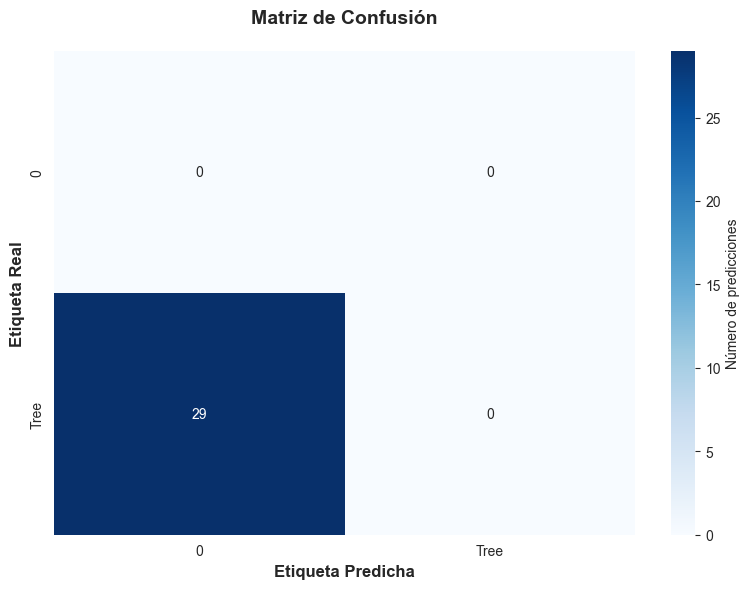

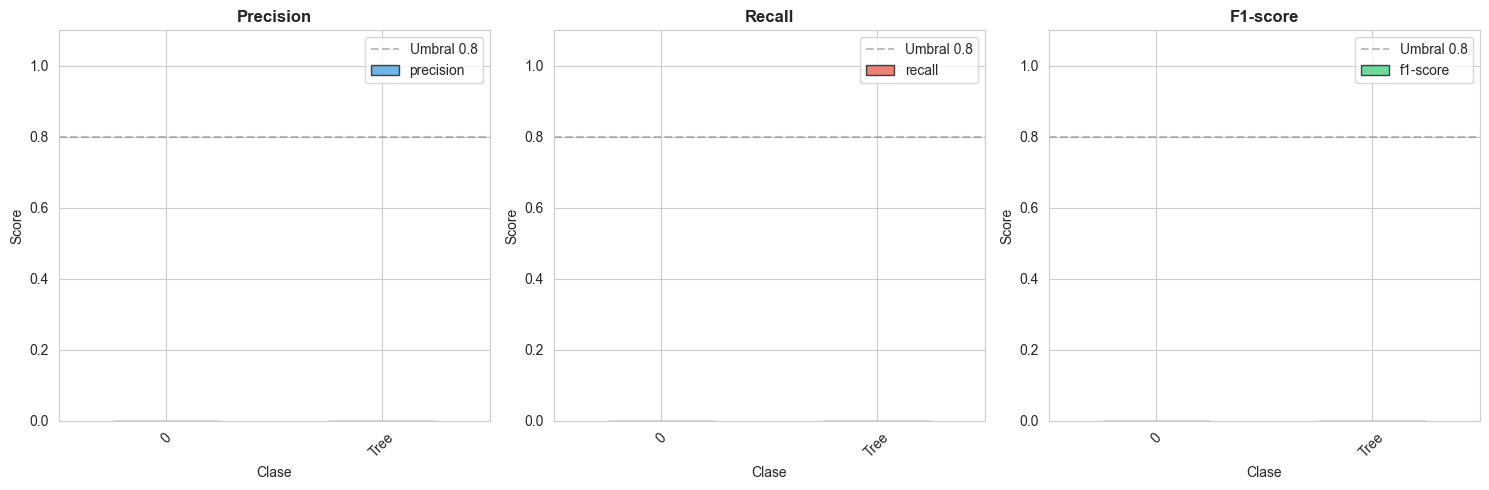

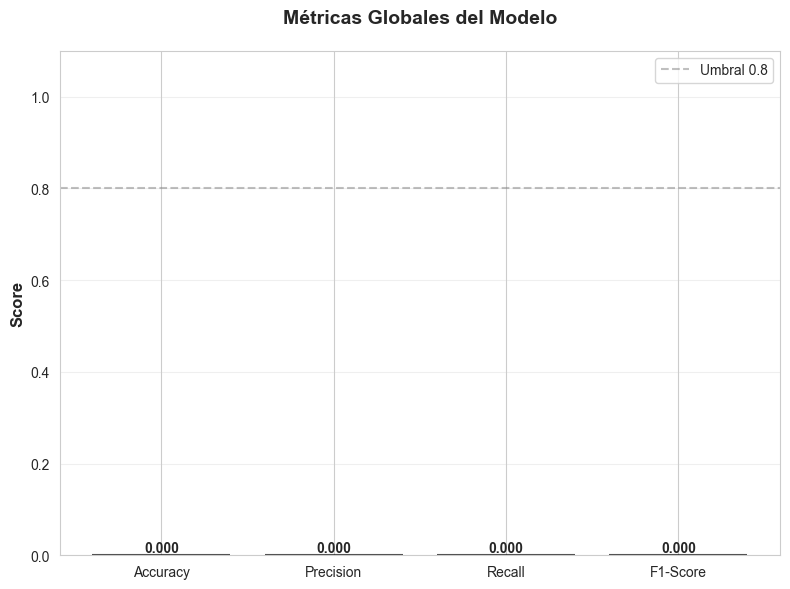

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    classification_report, 
    precision_score, 
    recall_score, 
    f1_score
)

# ==============================================================================
# CONFIGURACIÓN - Ajusta estas rutas según tu proyecto
# ==============================================================================
val_path = "C:/Users/Brayan/Desktop/Salida infierno/DEepforest/val_annotations.csv"  # CSV con anotaciones de validación
tiles_dir = "C:/Users/Brayan/Desktop/Salida infierno/DEepforest/images"          # Directorio con imágenes/tiles
model_path = "C:/Users/Brayan/Desktop/Salida infierno/DEepforest/best_model-epoch=00-train_loss_epoch=1.05.ckpt"      # Modelo entrenado
output_dir = "C:/Users/Brayan/Desktop/Salida infierno/DEepforest/Resultados"    # Carpeta para guardar resultados

# Crear directorio de salida
os.makedirs(output_dir, exist_ok=True)

# ==============================================================================
# CARGAR DATOS Y MODELO
# ==============================================================================
print("📂 Cargando datos de validación...")
val_df = pd.read_csv(val_path)
print(f"✓ {len(val_df)} anotaciones cargadas")

# Cargar el modelo (ajusta según tu código de carga)
# from deepforest import main
# model = main.deepforest()
# model.load_model(model_path)

# ==============================================================================
# GENERAR PREDICCIONES
# ==============================================================================
print("\n🔮 Generando predicciones...")
predictions = model.predict_file(
    csv_file=val_path,
    root_dir=tiles_dir,
    size=model.config["validation"]["size"]
)

if predictions is None or predictions.empty:
    raise ValueError("❌ No se generaron predicciones. Verifica las rutas y anotaciones.")

print(f"✓ {len(predictions)} predicciones generadas")

# ==============================================================================
# PREPARAR DATOS PARA EVALUACIÓN
# ==============================================================================
print("\n📊 Preparando datos para evaluación...")

# OPCIÓN 1: Evaluar por IMAGEN (una predicción por imagen)
# Esto es útil cuando cada imagen tiene una clase y queremos saber si la detectamos
print("\n🔍 Agrupando predicciones por imagen...")

# Obtener las imágenes únicas
unique_images = val_df["image_path"].unique()
print(f"Total de imágenes únicas: {len(unique_images)}")

y_true = []
y_pred = []
images_matched = []
images_no_detection = []

for image_name in unique_images:
    # Ground truth para esta imagen
    gt_labels = val_df[val_df["image_path"] == image_name]["label"].values
    
    # Predicciones para esta imagen
    pred_subset = predictions[predictions["image_path"] == image_name]
    
    if len(pred_subset) > 0:
        # Hay al menos una predicción para esta imagen
        # Usamos la predicción con mayor score (o la primera si no hay score)
        if "score" in pred_subset.columns:
            best_pred = pred_subset.loc[pred_subset["score"].idxmax(), "label"]
        else:
            best_pred = pred_subset.iloc[0]["label"]
        
        # Agregamos la etiqueta real (primera anotación) y la predicción
        y_true.append(str(gt_labels[0]))
        y_pred.append(str(best_pred))
        images_matched.append(image_name)
    else:
        # No hay predicciones para esta imagen
        images_no_detection.append(image_name)
        # Opcional: agregar como "sin detección" o ignorar
        # y_true.append(str(gt_labels[0]))
        # y_pred.append("no_detection")

# Verificar longitudes
print(f"\n📊 Resultados del emparejamiento:")
print(f"✓ Imágenes con predicciones: {len(images_matched)}")
print(f"⚠️ Imágenes sin predicciones: {len(images_no_detection)}")
print(f"Ground truth: {len(y_true)} muestras")
print(f"Predicciones: {len(y_pred)} muestras")

if len(images_no_detection) > 0:
    print(f"\n⚠️ Advertencia: {len(images_no_detection)} imágenes no tuvieron detecciones")
    print("   Primeras 5 imágenes sin detección:")
    for img in images_no_detection[:5]:
        print(f"     - {img}")

# Si aún hay problemas, mostrar información de depuración
if len(y_true) != len(y_pred):
    print(f"\n❌ ERROR: Longitudes aún no coinciden")
    print(f"   Ground truth: {len(y_true)}")
    print(f"   Predicciones: {len(y_pred)}")
    raise ValueError("No se pudo emparejar correctamente las predicciones con ground truth")

# ==============================================================================
# CALCULAR MÉTRICAS
# ==============================================================================
print("\n📈 Calculando métricas...")

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\n{'='*50}")
print(f"📊 RESULTADOS DEL MODELO")
print(f"{'='*50}")
print(f"✓ Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
print(f"✓ Precision: {prec:.4f}")
print(f"✓ Recall:    {rec:.4f}")
print(f"✓ F1-Score:  {f1:.4f}")
print(f"{'='*50}\n")

# ==============================================================================
# VISUALIZACIONES
# ==============================================================================
print("📊 Generando visualizaciones...\n")

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# --- 1. MATRIZ DE CONFUSIÓN ---
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
labels = sorted(set(y_true + y_pred))

sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'label': 'Número de predicciones'},
    ax=ax
)
ax.set_xlabel("Etiqueta Predicha", fontsize=12, fontweight='bold')
ax.set_ylabel("Etiqueta Real", fontsize=12, fontweight='bold')
ax.set_title("Matriz de Confusión", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"), dpi=300, bbox_inches='tight')
plt.show()

# --- 2. MÉTRICAS POR CLASE ---
report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()

# Excluir filas de resumen para la visualización por clase
class_metrics = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['precision', 'recall', 'f1-score']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    if metric in class_metrics.columns:
        class_metrics[metric].plot(
            kind='bar', 
            ax=axes[idx], 
            color=color, 
            alpha=0.7,
            edgecolor='black'
        )
        axes[idx].set_title(f'{metric.capitalize()}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Score', fontsize=10)
        axes[idx].set_xlabel('Clase', fontsize=10)
        axes[idx].set_ylim(0, 1.1)
        axes[idx].axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label='Umbral 0.8')
        axes[idx].legend()
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "metrics_by_class.png"), dpi=300, bbox_inches='tight')
plt.show()

# --- 3. RESUMEN DE MÉTRICAS GLOBALES ---
fig, ax = plt.subplots(figsize=(8, 6))

metrics_summary = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1
}

bars = ax.bar(
    metrics_summary.keys(), 
    metrics_summary.values(),
    color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'],
    alpha=0.7,
    edgecolor='black',
    linewidth=1.5
)

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height,
        f'{height:.3f}',
        ha='center', 
        va='bottom',
        fontweight='bold'
    )

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Métricas Globales del Modelo', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 1.1)
ax.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label='Umbral 0.8')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "global_metrics.png"), dpi=300, bbox_inches='tight')
plt.show()

# --- 4. DISTRIBUCIÓN DE CLASES ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ground Truth
pd.Series(y_true).value_counts().plot(
    kind='bar', 
    ax=axes[0], 
    color='#3498db', 
    alpha=0.7,
    edgecolor='black'
)
axes[0].set_title('Distribución Real de Clases', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=10)
axes[0].set_xlabel('Clase', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# Predicciones
pd.Series(y_pred).value_counts().plot(
    kind='bar', 
    ax=axes[1], 
    color='#e74c3c', 
    alpha=0.7,
    edgecolor='black'
)
axes[1].set_title('Distribución Predicha de Clases', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=10)
axes[1].set_xlabel('Clase', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "class_distribution.png"), dpi=300, bbox_inches='tight')
plt.show()

# ==============================================================================
# GUARDAR RESULTADOS
# ==============================================================================
print("\n💾 Guardando resultados...")

# Guardar reporte de clasificación
metrics_path = os.path.join(output_dir, "classification_report.csv")
report_df.to_csv(metrics_path, index=True)
print(f"✓ Reporte guardado: {metrics_path}")

# Guardar resumen de métricas
summary_path = os.path.join(output_dir, "metrics_summary.txt")
with open(summary_path, 'w') as f:
    f.write("="*50 + "\n")
    f.write("RESUMEN DE EVALUACIÓN - DEEPFOREST MODEL\n")
    f.write("="*50 + "\n\n")
    f.write(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)\n")
    f.write(f"Precision: {prec:.4f}\n")
    f.write(f"Recall:    {rec:.4f}\n")
    f.write(f"F1-Score:  {f1:.4f}\n")
    f.write("\n" + "="*50 + "\n")
    f.write("REPORTE DETALLADO POR CLASE\n")
    f.write("="*50 + "\n\n")
    f.write(report_df.to_string())

print(f"✓ Resumen guardado: {summary_path}")

# Guardar predicciones completas
predictions_path = os.path.join(output_dir, "predictions.csv")
predictions.to_csv(predictions_path, index=False)
print(f"✓ Predicciones guardadas: {predictions_path}")

print(f"\n✅ Evaluación completa! Resultados guardados en: {output_dir}/")
print("\nArchivos generados:")
print("  📊 confusion_matrix.png")
print("  📊 metrics_by_class.png")
print("  📊 global_metrics.png")
print("  📊 class_distribution.png")
print("  📄 classification_report.csv")
print("  📄 metrics_summary.txt")
print("  📄 predictions.csv")

## Pasado del codigo

In [ ]:
'''
# --- 8. EVALUATE MODEL ---
if not val_df.empty and os.path.exists(model_path):
    print("\n📊 Evaluating on validation set...")

    # Predicción por tiles
    predictions = model.predict_tile(
    path=raster_path,
    patch_size=800,
    patch_overlap=0.2
    )

    # --- 8. SAVE PREDICTIONS FROM TILE INFERENCE ---
print("\n💾 Guardando predicciones por tiles...")

preds_path = os.path.join(output_dir, "predicciones_tiles.csv")
predictions.to_csv(preds_path, index=False)

print(f"✅ Predicciones guardadas en: {preds_path}")

# --- 9. VISUALIZE SAMPLE PREDICTIONS ---
import os
import matplotlib.pyplot as plt
from PIL import Image

sample_tiles = val_imgs[:3] if len(val_imgs) >= 3 else list(unique_images)[:3]
if len(sample_tiles) == 0:
    sample_tiles = [val_imgs[0]]

fig, axes = plt.subplots(1, len(sample_tiles), figsize=(15, 5))
if len(sample_tiles) == 1:
    axes = [axes]

print("\n🖼️ Generating sample predictions...")
for idx, tile_name in enumerate(sample_tiles):
    tile_path = os.path.join(tiles_dir, tile_name)
    print(f"Predicting {tile_path}...")

    # Predict
    pred_df = model.predict_image(path=tile_path)

    # Load image
    img = Image.open(tile_path)
    axes[idx].imshow(img)

    # Draw predictions
    if pred_df is not None and not pred_df.empty:
        for _, row in pred_df.iterrows():
            rect = plt.Rectangle(
                (row['xmin'], row['ymin']),
                row['xmax'] - row['xmin'],
                row['ymax'] - row['ymin'],
                fill=False,
                edgecolor='red',
                linewidth=2
            )
            axes[idx].add_patch(rect)
            axes[idx].text(
                row['xmin'], row['ymin'] - 5,
                f"{row['score']:.2f}",
                color='red',
                fontsize=8,
                weight='bold'
            )

    axes[idx].set_title(f"{tile_name}\n{len(pred_df) if pred_df is not None else 0} detections")
    axes[idx].axis('off')

plt.tight_layout()
preds_path = os.path.join(output_dir, "sample_predictions.png")
plt.savefig(preds_path, dpi=150, bbox_inches='tight')
print(f"✅ Visualization saved to: {preds_path}")
plt.show()
'''

NameError: name 'val_df' is not defined

In [ ]:
results = model.evaluate(csv_file=val_path, root_dir=tiles_dir, iou_threshold=0.5)
print(results)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# --- EVALUAR DETALLES DE PRECISIÓN ---
if not val_df.empty and os.path.exists(model_path):
    print("\n📊 Evaluando predicciones detalladas...")

    # Obtener predicciones sobre el conjunto de validación
    predictions = model.predict_file(csv_file=val_path, root_dir=tiles_dir)

    # Las predicciones incluyen columnas: image_path, xmin, ymin, xmax, ymax, score, label
    # Puedes combinarlas con tus anotaciones reales (val_df)

    # Convertir ambos DataFrames a listas de clases detectadas (por imagen)
    y_true = []
    y_pred = []

    for image_name in val_df["image_path"].unique():
        gt_labels = val_df[val_df["image_path"] == image_name]["label"].tolist()
        pred_labels = predictions[predictions["image_path"] == image_name]["label"].tolist()
        
        # En detección, emparejar etiquetas puede ser complejo,
        # pero si cada imagen tiene un solo objeto o una clase dominante, puedes usar:
        if len(pred_labels) > 0:
            y_pred.append(pred_labels[0])
            y_true.append(gt_labels[0])
    
    # Calcular métricas
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)

    print(f"\n✅ Accuracy: {acc:.4f}")
    print("\n📋 Classification Report:")
    print(report)
    print("\n🧩 Matriz de Confusión:")
    print(cm)


NameError: name 'val_df' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión - DeepForest")
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas verdaderas")
plt.show()
